## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
# Compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:

    img = plt.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        if len(fname) == 29: # img with single digit number
            cv2.imwrite('./output_images/corners_found'+fname[-5]+'.jpg', img)
        else:
            cv2.imwrite('./output_images/corners_found'+fname[-6:-4]+'.jpg', img)


# Apply a distortion correction on an raw image

Text(0.5,1,'Undistorted Image')

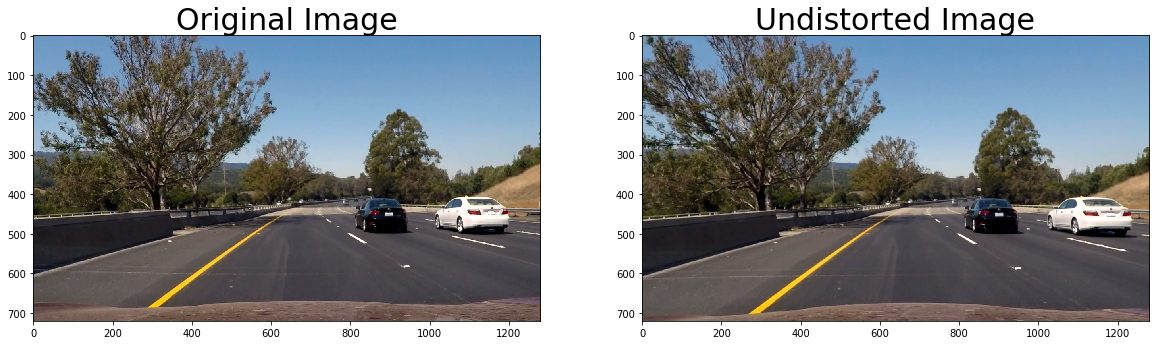

In [2]:
import pickle
%matplotlib inline

test = 'test6'
img = plt.imread('./test_images/' + test + '.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

undistorted = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('./output_images/' + test + '_undistorted.jpg', cv2.cvtColor(undistorted, cv2.COLOR_RGB2BGR))

# Save the camera calibration result for later use (won't worry about rvecs and tvecs)
dist_pickle = {}
dist_pickle['mtx'] = mtx
dist_pickle['dist'] = dist
pickle.dump(dist_pickle, open('./dist_pickle.p', 'wb'))
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=30)

# Use color transforms, gradients, etc., to create a thresholded binary image

Text(0.5,1,'Binary Combined (Color and Gradients)')

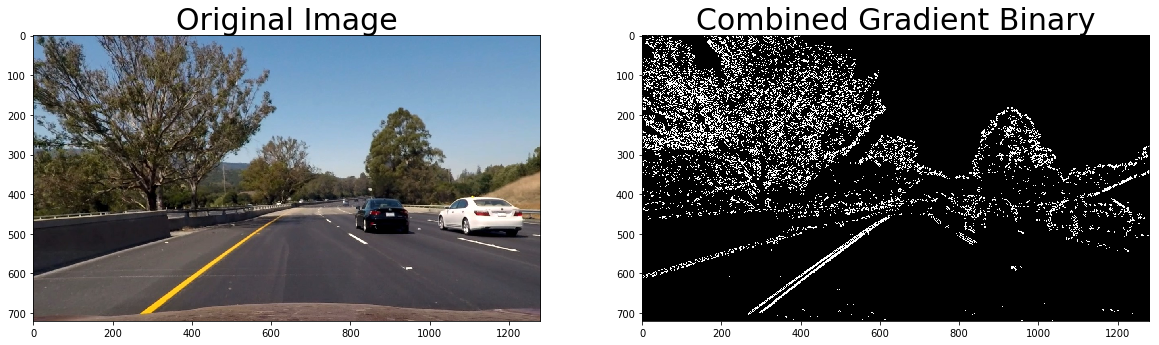

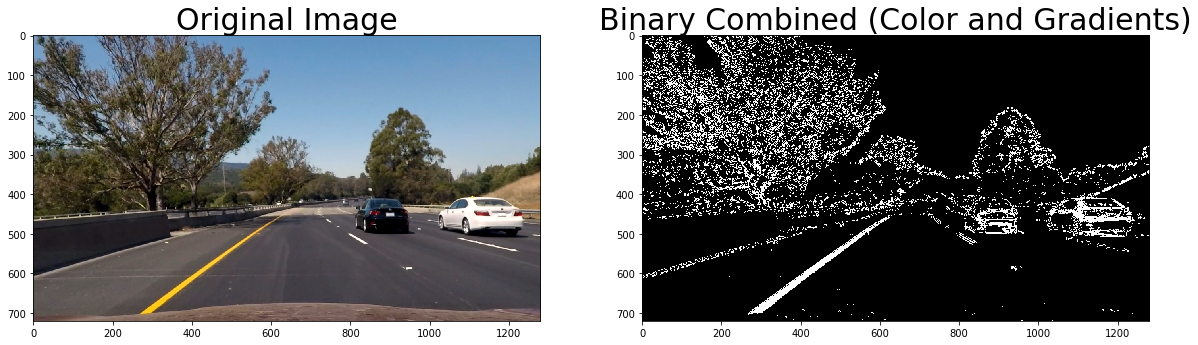

In [3]:
# x and y directional gradient
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply the x / y gradient with the openCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # rescale back to 8-bit integer
    scaled_sobel = np.uint(255*abs_sobel/np.max(abs_sobel))
    # create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # return result
    return binary_output

# gradient magnitude
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # create binary image
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

# gradient direction
def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

# Choose a sobel kernel size
ksize = 9

#img = plt.imread('./test_images/signs_vehicles_xygrad.jpg')

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(undistorted, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(undistorted, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(undistorted, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_thresh(undistorted, sobel_kernel=ksize, thresh=(0.7, 1.3))
# Combine the 3 thresholds 
grad_combined = np.zeros_like(dir_binary)
grad_combined[((gradx==1) & (grady==1)) | ((mag_binary==1) & (dir_binary==1))] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(grad_combined, cmap='gray')
ax2.set_title('Combined Gradient Binary', fontsize=30)


# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

hls_binary = hls_select(undistorted, thresh=(170, 255))

# Combine color and gradient
combined = np.zeros_like(hls_binary).astype(np.uint8)
combined[(grad_combined == 1) | (hls_binary == 1)] = 255
binary_combined = np.dstack((combined,combined,combined))
cv2.imwrite('./output_images/' + test + 'binary_combined.jpg', binary_combined)

def apply_thresholds(img, ksize):
    # Apply each of the gradient thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_thresh(img, sobel_kernel=ksize, thresh=(0.7, 1.3))
    # Combine the 3 thresholds 
    grad_combined = np.zeros_like(dir_binary)
    grad_combined[((gradx==1) & (grady==1)) | ((mag_binary==1) & (dir_binary==1))] = 1

    hls_binary = hls_select(img, thresh=(170, 255))
    # Combine color and gradient
    combined = np.zeros_like(hls_binary)
    combined[(grad_combined == 1) | (hls_binary == 1)] = 1
    
    return combined


# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(binary_combined)#, cmap='gray')
ax2.set_title('Binary Combined (Color and Gradients)', fontsize=30)

# Apply a perspective transform to rectify binary image ("birds-eye view")

Text(0.5,1,'Warped')

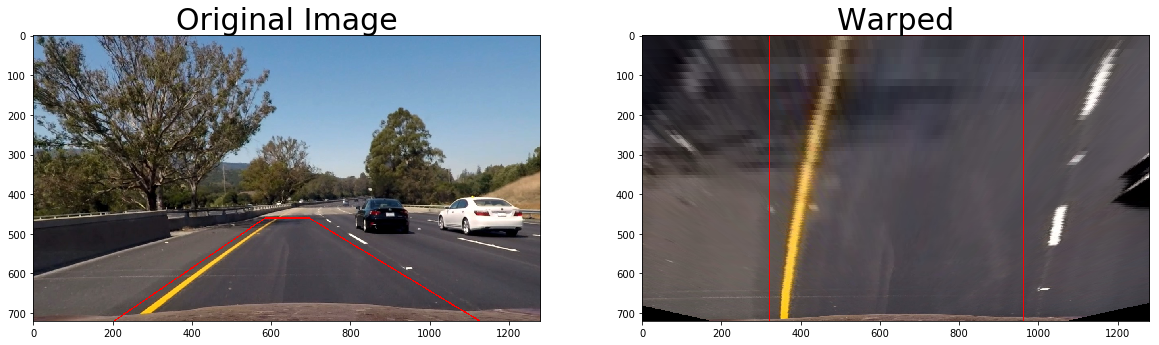

In [4]:
def warper(img, src, dst):
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image
    return warped

src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

warped = warper(undistorted, src, dst)
undistorted_with_lines = np.copy(undistorted)
warped_with_lines = np.copy(warped)
cv2.polylines(undistorted_with_lines, np.int32([src]), isClosed=True, color=(255,0,0), thickness=2)
cv2.polylines(warped_with_lines, np.int32([dst]), isClosed=True, color=(255,0,0), thickness=2)
cv2.imwrite('./output_images/'+test+'warped.jpg', cv2.cvtColor(warped, cv2.COLOR_RGB2BGR))
cv2.imwrite('./output_images/'+test+'warped_with_lines.jpg', cv2.cvtColor(warped_with_lines, cv2.COLOR_RGB2BGR))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(undistorted_with_lines)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped_with_lines, cmap='gray')
ax2.set_title('Warped', fontsize=30)

# Detect lane pixels and fit to find the lane boundary.

True

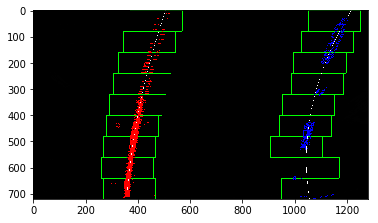

In [5]:

def find_lane_pixels(binary_warped):
    # take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:, :], axis=0)
    # create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # HYPERPARAMETERS
    # choose the number of sliding windows
    nwindows = 9
    # set the width of the windows +/- margin
    margin = 100
    # set minimum number of pixels foudn to recenter window
    minpix = 50
    
    # set height of windows, based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # step through the windows one by one
    for window in range(nwindows):
        # identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        # find the four below boundaries of the window
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        
        # identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # if you found > minpix pixels, recenter next window
        # (right or leftx_current) on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # concatenate the arrays of indices (previously was a list of list of pixels)
    try: 
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # avoid error if the above is not implemented fully
        pass
    
    # extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):
    # find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    # fit a second order polynomial to each using 'np.polyfit'
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # avoids an error if 'left' + 'right_fit' are still none or incorrect
        print('The function failed to fit a line')
        left_fitx = 1*ploty**2 + ploty
        right_fitx = 1*ploty**2 + ploty
    
    # Visualization
    # colors in the left and right lane regions
    out_img[lefty, leftx] = [255,0,0]
    out_img[righty, rightx] = [0,0,255]
    out_img[ploty.astype(np.int32), left_fitx.astype(np.int32)] = [255,255,255]
    out_img[ploty.astype(np.int32), right_fitx.astype(np.int32)] = [255,255,255]
    
    
    # plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    
    return out_img, left_fit, right_fit, leftx, lefty, rightx, righty

warped = warper(undistorted, src, dst)
binary_warped = apply_thresholds(warped, ksize)
warped_with_lanes, left_fit, right_fit, leftx, lefty, rightx, righty = fit_polynomial(binary_warped)
#fig, ax = plt.subplots(figsize=(20, 10))
#ax.imshow(out_img)
plt.imshow(warped_with_lanes)
cv2.imwrite('./output_images/'+test+'fit_poly.jpg', cv2.cvtColor(warped_with_lanes, cv2.COLOR_RGB2BGR))

# Determine curvature of the lane and vehicle position with respect to center

In [6]:
def measure_curvature_pixels(img, left_fit, right_fit):
    # define y-value where we want radius of curvature
    # we'll choose the max y-value, corresponding to the bottom of image
    y_eval = img.shape[0]
    
    # calculation of radius of curvature
    left_curverad = (1+(2*left_fit[0]*y_eval+left_fit[1])**2)**1.5 / np.absolute(2*left_fit[0])
    right_curverad = (1+(2*right_fit[0]*y_eval+right_fit[1])**2)**1.5 / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

ym_per_pix = 30/720
xm_per_pix = 3.7/700

def measure_curvature_real(img, leftx, lefty, rightx, righty):
    y_eval = img.shape[0]
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

left_cr_real, right_cr_real = measure_curvature_real(binary_warped, leftx, lefty, rightx, righty)
print(left_cr_real)
print(right_cr_real)

def measure_position(img, left_fit, right_fit, xm):
    y_eval = img.shape[0]
    left = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    pos = (img.shape[1]/2 - (left+right)/2) * xm
    return pos

pos = measure_position(binary_warped, left_fit, right_fit, xm_per_pix)
print(pos)

900.977927216
309.908103015
-0.355597922866


# Warp the detected lane boundaries back onto the original image

True

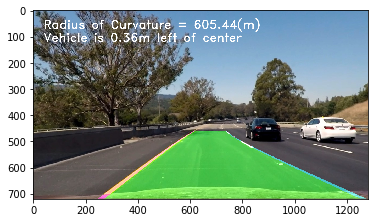

In [7]:
def draw_lane(img, binary_warped, src, dst, left_fit, right_fit, curve_rad, pos):
    new_img = np.copy(img)
    # create a blank warped image to draw the lane on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    img_size = (img.shape[1], img.shape[0])
    newwarp = cv2.warpPerspective(color_warp, M_inv, img_size)
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result


curve_rad = (left_cr_real + right_cr_real) / 2
plotted_img = draw_lane(undistorted, binary_warped, src, dst, left_fit, right_fit, curve_rad, pos)
plt.imshow(plotted_img)


def write_data(img, curve_rad, pos): 
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Radius of Curvature = ' + '{:04.2f}'.format(curve_rad) + '(m)'
    cv2.putText(img, text, (40,70), font, 1.5, (255,255,255), 2, cv2.LINE_AA)
    if (pos > 0):
        text = 'Vehicle is ' + '{:04.2f}'.format(pos) + 'm ' + 'right of center'
    else:
        text = 'Vehicle is ' + '{:04.2f}'.format(0-pos) + 'm ' + 'left of center'
    cv2.putText(img, text, (40,120), font, 1.5, (255,255,255), 2, cv2.LINE_AA)
    return img

annotated_img = write_data(plotted_img, curve_rad, pos)
plt.imshow(annotated_img)
cv2.imwrite('./output_images/'+test+'output.jpg', cv2.cvtColor(annotated_img, cv2.COLOR_RGB2BGR))

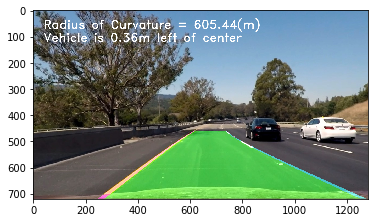

In [8]:
def pipeline(img):
    new_img = np.copy(img)
    img_undistorted = cv2.undistort(img, mtx, dist, None, mtx)

    warped = warper(img_undistorted, src, dst)
    binary_warped = apply_thresholds(warped, ksize)
    #binary = apply_thresholds(img_undistorted, ksize)
    #binary_warped = warper(binary, src, dst)
    warped_with_lanes, left_fit, right_fit, leftx, lefty, rightx, righty = fit_polynomial(binary_warped)
    left_cr_real, right_cr_real = measure_curvature_real(binary_warped, leftx, lefty, rightx, righty)
    pos = measure_position(binary_warped, left_fit, right_fit, xm_per_pix)
    
    curve_rad = (left_cr_real + right_cr_real) / 2
    plotted_img = draw_lane(img_undistorted, binary_warped, src, dst, left_fit, right_fit, curve_rad, pos)
    result = write_data(plotted_img, curve_rad, pos)
    return result

img = plt.imread('./test_images/test6.jpg')
plt.imshow(pipeline(img))

In [29]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output_name = 'output.mp4'
intput = VideoFileClip('project_video.mp4')
output = intput.fl_image(pipeline)
%time output.write_videofile(output_name, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [06:56<00:00,  3.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 4min 14s, sys: 42.2 s, total: 4min 56s
Wall time: 6min 58s
